# Imports

In [1]:
#!pip install -U flwr["simulation"]==1.9.0 torch torchvision GPUtil

In [16]:
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple, NamedTuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10
import time
import flwr as fl
from scipy import stats as st
import json

DEVICE = torch.device("cuda")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

Training on cuda using PyTorch 2.3.1 and Flower 1.9.0


In [17]:
from logging import INFO, DEBUG
from flwr.common.logger import log

In [18]:
class ClientMetrics(NamedTuple):
    epoch: int
    loss: float
    accuracy: float
    round: int = 0
    cid: int = 0

In [19]:
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
   process = psutil.Process(os.getpid())
   print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
   print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 110.6 GB  | Proc size: 558.2 MB
GPU RAM Free: 15048MB | Used: 1122MB | Util   7% | Total 16376MB


# Dataset

In [20]:
NUM_CLIENTS = 10


def load_datasets(num_clients: int):
    # Download and transform CIFAR-10 (train and test)
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    trainset = CIFAR10("./dataset", train=True, download=True, transform=transform)
    testset = CIFAR10("./dataset", train=False, download=True, transform=transform)

    # Split training set into `num_clients` partitions to simulate different local datasets
    partition_size = len(trainset) // num_clients
    lengths = [partition_size] * num_clients
    datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = len(ds) // 10  # 10 % validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=32, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=32))
    testloader = DataLoader(testset, batch_size=32)
    return trainloaders, valloaders, testloader


trainloaders, valloaders, testloader = load_datasets(NUM_CLIENTS)

Files already downloaded and verified
Files already downloaded and verified


# Model

In [23]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)



def train(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    metrics = []
    for epoch in range(epochs):  # Use the passed 'epochs' variable here
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss.item()  # Make sure to call .item() to get the scalar value
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        metrics.append(ClientMetrics(epoch, epoch_loss, epoch_acc))
        print(f"Epoch {epoch}: train loss {epoch_loss:.6f}, accuracy {epoch_acc:.6f}")
        
    return metrics


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [24]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.cid}] fit, config: {config}")
        set_parameters(self.net, parameters)
        epochs = config.get("epochs", 1)
        start_time = time.time()  # Start time measurement
        metrics = train(self.net, self.trainloader, epochs)
        training_time = time.time() - start_time  # Calculate duration
        print(f"Training time for Client {self.cid}: {training_time:.2f} seconds")
        
        return get_parameters(self.net), len(self.trainloader), {"training_time": training_time, "metrics": json.dumps(metrics)}



    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(cid) -> FlowerClient:
    net = Net().to(DEVICE)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FlowerClient(cid, net, trainloader, valloader).to_client()

# Custom Strategy

In [25]:
from typing import Callable, Union

from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    MetricsAggregationFn,
    NDArrays,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg


class FedCustom(fl.server.strategy.Strategy):
    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
    ) -> None:
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.client_training_times: Dict[int, List[float]] = {}
        self.client_metrics: Dict[int, List[ClientMetrics]] = {}
        self.loss_extreme: Dict[int, Tuple[int, float, float]] = {}
        self.accuracy_extreme: Dict[int, Tuple[int, float, float]] = {}
    def __repr__(self) -> str:
        return "FedCustom"

    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        """Initialize global model parameters."""
        net = Net()
        ndarrays = get_parameters(net)
        return fl.common.ndarrays_to_parameters(ndarrays)

    def configure_fit(self, server_round: int, parameters: Parameters, client_manager: ClientManager):
        sample_size, min_num_clients = self.num_fit_clients(client_manager.num_available())
        clients = client_manager.sample(num_clients=sample_size, min_num_clients=min_num_clients)
        epochs_sc = 10
        

        standard_config = {"lr": 0.001, "epochs": epochs_sc}
        
        fit_configurations = []
        mode_time = []
        
        for client in clients:
            last_time = self.client_training_times.get(client.cid, [0,])[-1] # Default to 0 if no time recorded # Yash has changed this as we now save last time of all epochs as key: value - cid: list of times
            print(f"This is ths last time not a fantasy {last_time}and {client.cid}habhhahah")
            
            
            mode_time.append(round(last_time,2))
            print(f"this is tehb mode time {mode_time}")
           

        modest_value = st.mode(np.array(mode_time))
        print(f"Yeh h modest valueueueueu{modest_value}")
        print(f"yeh h server round {server_round}")
        min_value, max_value= np.min(modest_value),np.max(modest_value)
        print(f"this is the min value {min_value} and this is the max value {max_value}")
      
        
        if min_value == max_value:
            epochs_hl = epochs_sc   
        else:
            epochs_hl = int(np.floor((max_value-min_value)/max_value * epochs_sc)) 

        higher_lr_config = {"lr": 0.0001, "epochs": epochs_hl}
        print(f"The epochs for the higher lr is {epochs_hl} and the epochs for the standard lr is {epochs_sc}")




        for client in clients:
            # Choose config based on the previous training time
            last_time = self.client_training_times.get(client.cid, [0,])[-1]  # Default to 0 if no time recorded # Yash has changed this as we now save last time of all epochs as key: value - cid: list of times
            print(f"This is the last time {last_time}")
            
            


            config_to_use = standard_config if last_time < modest_value.mode else higher_lr_config
            fit_configurations.append((client, FitIns(parameters, config_to_use)))

        return fit_configurations
    
    def parse_metrics(self, cid: int, server_round: int, metrics: str): # this function has been added to parse the metrics from the client
        client_data: List[ClientMetrics] = json.loads(metrics)
        data_store: List[ClientMetrics] = self.client_metrics.setdefault(cid, [])
        last_epoch: int = len(data_store)
        for data in client_data:
            data_store.append(ClientMetrics(last_epoch, data[1], data[2], round=server_round, cid=cid))
            last_epoch += 1

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        for client, fit_res in results:
            # Update training times for each client
            self.client_training_times.setdefault(client.cid, []).append(fit_res.metrics.get("training_time", 0)) # Yash has changed this as we now save last time of all epochs as key: value - cid: list of times
            self.parse_metrics(client.cid,server_round, fit_res.metrics.get("metrics", None))
        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        metrics_aggregated = {}
        return parameters_aggregated, metrics_aggregated


    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        """Configure the next round of evaluation."""
        if self.fraction_evaluate == 0.0:
            return []
        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Sample clients
        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Return client/config pairs
        return [(client, evaluate_ins) for client in clients]

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated

    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        """Evaluate global model parameters using an evalua
        tion function."""

        # Let's assume we won't perform the global model evaluation on the server side.
        
        return None

    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Return sample size and required number of clients."""
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Use a fraction of available clients for evaluation."""
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients

In [26]:
if DEVICE.type == "cuda":
    # Use a single client to train the global model
    client_resources = {"num_gpus": .125, "num_cpus": 1} 

In [27]:
strategy = FedCustom()
#fl.common.logger.configure(identifier="myflExpMY", filename="FLLOG_my.txt")
history = fl.simulation.start_simulation(client_fn=client_fn,
                                         num_clients=10,
                                         config=fl.server.ServerConfig(num_rounds=10),
                                         strategy=strategy,  # <-- pass the new strategy here
                                         client_resources=client_resources,

)
history


INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
2024-12-15 11:57:55,776	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 32.0, 'object_store_memory': 33051102412.0, 'accelerator_type:RTX': 1.0, 'memory': 67119238964.0, 'GPU': 1.0, 'node:127.0.0.1': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_gpus': 0.125, 'num_cpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 8 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Evaluating initial global parameters
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 0and 6habhhahah
this is tehb mode time [0]
This is ths last time not a fantasy 0and 3habhhahah
this is tehb mode time [0, 0]
This is ths last time not a fantasy 0and 8habhhahah
this is tehb mode time [0, 0, 0]
This is ths last time not a fantasy 0and 0habhhahah
this is tehb mode time [0, 0, 0, 0]
This is ths last time not a fantasy 0and 1habhhahah
this is tehb mode time [0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 7habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 2habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 5habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 9habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 4habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Yeh h modest valueueueueuModeResult(mode=0, count=10)
yeh h server round 1


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=32388) Epoch 9: train loss 0.035198, accuracy 0.604000 [repeated 4x across cluster]
(ClientAppActor pid=32388) [Client 1] evaluate, config: {}
(ClientAppActor pid=32388) Training time for Client 4: 24.75 seconds
(ClientAppActor pid=32072) [Client 2] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=42196) [Client 4] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 23.91974711418152and 5habhhahah
this is tehb mode time [23.92]
This is ths last time not a fantasy 23.08940052986145and 1habhhahah
this is tehb mode time [23.92, 23.09]
This is ths last time not a fantasy 23.641006231307983and 7habhhahah
this is tehb mode time [23.92, 23.09, 23.64]
This is ths last time not a fantasy 23.72666645050049and 6habhhahah
this is tehb mode time [23.92, 23.09, 23.64, 23.73]
This is ths last time not a fantasy 23.42766785621643and 3habhhahah
this is tehb mode time [23.92, 23.09, 23.64, 23.73, 23.43]
This is ths last time not a fantasy 23.73974871635437and 2habhhahah
this is tehb mode time [23.92, 23.09, 23.64, 23.73, 23.43, 23.74]
This is ths last time not a fantasy 23.32249402999878and 0habhhahah
this is tehb mode time [23.92, 23.09, 23.64, 23.73, 23.43, 23.74, 23.32]
This is ths last time not a fantasy 24.75194549560547and 4habhhahah
this is tehb mode time [23.92, 23.09, 23.64, 23.73, 23.43, 23.74, 23.32, 24.75]
This is ths

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=6412) Epoch 8: train loss 0.025664, accuracy 0.706667 [repeated 3x across cluster]
(ClientAppActor pid=6412) [Client 0] evaluate, config: {}
(ClientAppActor pid=6412) Training time for Client 9: 22.08 seconds
(ClientAppActor pid=36288) [Client 2] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 20.76981258392334and 4habhhahah
this is tehb mode time [20.77]
This is ths last time not a fantasy 20.846967458724976and 5habhhahah
this is tehb mode time [20.77, 20.85]
This is ths last time not a fantasy 22.078986644744873and 9habhhahah
this is tehb mode time [20.77, 20.85, 22.08]
This is ths last time not a fantasy 20.61935067176819and 3habhhahah
this is tehb mode time [20.77, 20.85, 22.08, 20.62]
This is ths last time not a fantasy 20.94064474105835and 2habhhahah
this is tehb mode time [20.77, 20.85, 22.08, 20.62, 20.94]
This is ths last time not a fantasy 20.625981330871582and 6habhhahah
this is tehb mode time [20.77, 20.85, 22.08, 20.62, 20.94, 20.63]
This is ths last time not a fantasy 21.02029061317444and 1habhhahah
this is tehb mode time [20.77, 20.85, 22.08, 20.62, 20.94, 20.63, 21.02]
This is ths last time not a fantasy 19.86664581298828and 0habhhahah
this is tehb mode time [20.77, 20.85, 22.08, 20.62, 20.94, 20.63, 21.02, 19.87]
This is t

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=6412) Epoch 8: train loss 0.011803, accuracy 0.878222 [repeated 4x across cluster]
(ClientAppActor pid=6412) [Client 8] evaluate, config: {}
(ClientAppActor pid=6412) Training time for Client 8: 22.17 seconds
(ClientAppActor pid=48560) [Client 1] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 20.80528450012207and 9habhhahah
this is tehb mode time [20.81]
This is ths last time not a fantasy 20.576669692993164and 6habhhahah
this is tehb mode time [20.81, 20.58]
This is ths last time not a fantasy 22.14020538330078and 7habhhahah
this is tehb mode time [20.81, 20.58, 22.14]
This is ths last time not a fantasy 20.762855291366577and 3habhhahah
this is tehb mode time [20.81, 20.58, 22.14, 20.76]
This is ths last time not a fantasy 20.629202604293823and 1habhhahah
this is tehb mode time [20.81, 20.58, 22.14, 20.76, 20.63]
This is ths last time not a fantasy 22.17281460762024and 8habhhahah
this is tehb mode time [20.81, 20.58, 22.14, 20.76, 20.63, 22.17]
This is ths last time not a fantasy 20.474486589431763and 5habhhahah
this is tehb mode time [20.81, 20.58, 22.14, 20.76, 20.63, 22.17, 20.47]
This is ths last time not a fantasy 20.289543390274048and 2habhhahah
this is tehb mode time [20.81, 20.58, 22.14, 20.76, 20.63, 22.17, 20.47, 20.29]
This is

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=35640) Epoch 8: train loss 0.006360, accuracy 0.938444 [repeated 4x across cluster]
(ClientAppActor pid=35640) [Client 8] evaluate, config: {}
(ClientAppActor pid=35640) Training time for Client 0: 22.34 seconds
(ClientAppActor pid=32072) [Client 7] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 22.2917160987854and 4habhhahah
this is tehb mode time [22.29]
This is ths last time not a fantasy 20.869539499282837and 8habhhahah
this is tehb mode time [22.29, 20.87]
This is ths last time not a fantasy 20.93584394454956and 6habhhahah
this is tehb mode time [22.29, 20.87, 20.94]
This is ths last time not a fantasy 23.27439832687378and 2habhhahah
this is tehb mode time [22.29, 20.87, 20.94, 23.27]
This is ths last time not a fantasy 22.336349487304688and 0habhhahah
this is tehb mode time [22.29, 20.87, 20.94, 23.27, 22.34]
This is ths last time not a fantasy 20.364280462265015and 1habhhahah
this is tehb mode time [22.29, 20.87, 20.94, 23.27, 22.34, 20.36]
This is ths last time not a fantasy 20.868359565734863and 3habhhahah
this is tehb mode time [22.29, 20.87, 20.94, 23.27, 22.34, 20.36, 20.87]
This is ths last time not a fantasy 20.71986198425293and 5habhhahah
this is tehb mode time [22.29, 20.87, 20.94, 23.27, 22.34, 20.36, 20.87, 20.72]
This is t

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=35640) [Client 6] evaluate, config: {}
(ClientAppActor pid=35640) Training time for Client 9: 24.40 seconds
(ClientAppActor pid=35640) Epoch 9: train loss 0.004147, accuracy 0.960444
(ClientAppActor pid=6412) [Client 1] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 24.404391765594482and 9habhhahah
this is tehb mode time [24.4]
This is ths last time not a fantasy 20.10429549217224and 0habhhahah
this is tehb mode time [24.4, 20.1]
This is ths last time not a fantasy 23.079682111740112and 8habhhahah
this is tehb mode time [24.4, 20.1, 23.08]
This is ths last time not a fantasy 22.002824068069458and 7habhhahah
this is tehb mode time [24.4, 20.1, 23.08, 22.0]
This is ths last time not a fantasy 22.736832857131958and 3habhhahah
this is tehb mode time [24.4, 20.1, 23.08, 22.0, 22.74]
This is ths last time not a fantasy 21.421461820602417and 4habhhahah
this is tehb mode time [24.4, 20.1, 23.08, 22.0, 22.74, 21.42]
This is ths last time not a fantasy 23.242464303970337and 5habhhahah
this is tehb mode time [24.4, 20.1, 23.08, 22.0, 22.74, 21.42, 23.24]
This is ths last time not a fantasy 20.570605039596558and 6habhhahah
this is tehb mode time [24.4, 20.1, 23.08, 22.0, 22.74, 21.42, 23.24, 20.57]
This is ths last time not

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=32388) Epoch 8: train loss 0.002512, accuracy 0.979778 [repeated 4x across cluster]
(ClientAppActor pid=32388) [Client 6] evaluate, config: {}
(ClientAppActor pid=32388) Training time for Client 2: 22.26 seconds
(ClientAppActor pid=32072) [Client 1] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 20.488685846328735and 3habhhahah
this is tehb mode time [20.49]
This is ths last time not a fantasy 21.09666156768799and 6habhhahah
this is tehb mode time [20.49, 21.1]
This is ths last time not a fantasy 21.15500569343567and 0habhhahah
this is tehb mode time [20.49, 21.1, 21.16]
This is ths last time not a fantasy 20.56571626663208and 7habhhahah
this is tehb mode time [20.49, 21.1, 21.16, 20.57]
This is ths last time not a fantasy 20.70165181159973and 4habhhahah
this is tehb mode time [20.49, 21.1, 21.16, 20.57, 20.7]
This is ths last time not a fantasy 21.141736268997192and 5habhhahah
this is tehb mode time [20.49, 21.1, 21.16, 20.57, 20.7, 21.14]
This is ths last time not a fantasy 21.541536808013916and 9habhhahah
this is tehb mode time [20.49, 21.1, 21.16, 20.57, 20.7, 21.14, 21.54]
This is ths last time not a fantasy 22.173628091812134and 1habhhahah
this is tehb mode time [20.49, 21.1, 21.16, 20.57, 20.7, 21.14, 21.54, 22.17]
This is ths last ti

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=41336) [Client 6] evaluate, config: {}
(ClientAppActor pid=41336) Training time for Client 8: 24.25 seconds
(ClientAppActor pid=41336) Epoch 9: train loss 0.003540, accuracy 0.966000
(ClientAppActor pid=48560) [Client 8] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 20.867688179016113and 5habhhahah
this is tehb mode time [20.87]
This is ths last time not a fantasy 24.249736309051514and 8habhhahah
this is tehb mode time [20.87, 24.25]
This is ths last time not a fantasy 22.266676664352417and 2habhhahah
this is tehb mode time [20.87, 24.25, 22.27]
This is ths last time not a fantasy 21.28014874458313and 1habhhahah
this is tehb mode time [20.87, 24.25, 22.27, 21.28]
This is ths last time not a fantasy 20.42215085029602and 7habhhahah
this is tehb mode time [20.87, 24.25, 22.27, 21.28, 20.42]
This is ths last time not a fantasy 21.087833881378174and 0habhhahah
this is tehb mode time [20.87, 24.25, 22.27, 21.28, 20.42, 21.09]
This is ths last time not a fantasy 23.77111577987671and 3habhhahah
this is tehb mode time [20.87, 24.25, 22.27, 21.28, 20.42, 21.09, 23.77]
This is ths last time not a fantasy 20.382219076156616and 9habhhahah
this is tehb mode time [20.87, 24.25, 22.27, 21.28, 20.42, 21.09, 23.77, 20.38]
This is

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=35640) [Client 6] evaluate, config: {}
(ClientAppActor pid=35640) Epoch 8: train loss 0.005595, accuracy 0.943333 [repeated 3x across cluster]
(ClientAppActor pid=35640) Training time for Client 4: 21.74 seconds
(ClientAppActor pid=6412) [Client 0] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 20.251579761505127and 3habhhahah
this is tehb mode time [20.25]
This is ths last time not a fantasy 20.809388875961304and 9habhhahah
this is tehb mode time [20.25, 20.81]
This is ths last time not a fantasy 21.74077272415161and 4habhhahah
this is tehb mode time [20.25, 20.81, 21.74]
This is ths last time not a fantasy 21.207382440567017and 8habhhahah
this is tehb mode time [20.25, 20.81, 21.74, 21.21]
This is ths last time not a fantasy 21.82644534111023and 6habhhahah
this is tehb mode time [20.25, 20.81, 21.74, 21.21, 21.83]
This is ths last time not a fantasy 20.76290798187256and 0habhhahah
this is tehb mode time [20.25, 20.81, 21.74, 21.21, 21.83, 20.76]
This is ths last time not a fantasy 20.105639934539795and 7habhhahah
this is tehb mode time [20.25, 20.81, 21.74, 21.21, 21.83, 20.76, 20.11]
This is ths last time not a fantasy 21.006686687469482and 2habhhahah
this is tehb mode time [20.25, 20.81, 21.74, 21.21, 21.83, 20.76, 20.11, 21.01]
This is

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=36288) Epoch 8: train loss 0.007180, accuracy 0.923111 [repeated 3x across cluster]
(ClientAppActor pid=36288) [Client 0] evaluate, config: {}
(ClientAppActor pid=36288) Training time for Client 5: 21.94 seconds
(ClientAppActor pid=32388) [Client 3] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 20.530571222305298and 8habhhahah
this is tehb mode time [20.53]
This is ths last time not a fantasy 20.766695737838745and 2habhhahah
this is tehb mode time [20.53, 20.77]
This is ths last time not a fantasy 21.613911867141724and 1habhhahah
this is tehb mode time [20.53, 20.77, 21.61]
This is ths last time not a fantasy 21.94195818901062and 5habhhahah
this is tehb mode time [20.53, 20.77, 21.61, 21.94]
This is ths last time not a fantasy 23.24256682395935and 7habhhahah
this is tehb mode time [20.53, 20.77, 21.61, 21.94, 23.24]
This is ths last time not a fantasy 20.292563676834106and 4habhhahah
this is tehb mode time [20.53, 20.77, 21.61, 21.94, 23.24, 20.29]
This is ths last time not a fantasy 21.15475082397461and 0habhhahah
this is tehb mode time [20.53, 20.77, 21.61, 21.94, 23.24, 20.29, 21.15]
This is ths last time not a fantasy 21.172958374023438and 3habhhahah
this is tehb mode time [20.53, 20.77, 21.61, 21.94, 23.24, 20.29, 21.15, 21.17]
This is

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=32388) [Client 8] evaluate, config: {}
(ClientAppActor pid=32388) Epoch 8: train loss 0.000214, accuracy 1.000000 [repeated 3x across cluster]
(ClientAppActor pid=32388) Training time for Client 6: 22.22 seconds
(ClientAppActor pid=42196) [Client 0] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures


(ClientAppActor pid=35640) [Client 6] evaluate, config: {} [repeated 5x across cluster]


INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 612.83s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.05602246608734131
INFO :      		round 2: 0.04206490125656128
INFO :      		round 3: 0.046025495648384096
INFO :      		round 4: 0.05279114190340042
INFO :      		round 5: 0.061714113283157346
INFO :      		round 6: 0.06597262794971466
INFO :      		round 7: 0.06934247298240662
INFO :      		round 8: 0.0707232800245285
INFO :      		round 9: 0.07415368716716766
INFO :      		round 10: 0.07864189982414246
INFO :      


History (loss, distributed):
	round 1: 0.05602246608734131
	round 2: 0.04206490125656128
	round 3: 0.046025495648384096
	round 4: 0.05279114190340042
	round 5: 0.061714113283157346
	round 6: 0.06597262794971466
	round 7: 0.06934247298240662
	round 8: 0.0707232800245285
	round 9: 0.07415368716716766
	round 10: 0.07864189982414246

In [28]:
def save_data_fedlr(client_metrics, rounds: int = 10):
    with open("data_fedlr.json", "w") as data:
        data.write(json.dumps(client_metrics))
save_data_fedlr(strategy.client_metrics)

# Plotting Functions

In [29]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.weight'] = 'bold'

def plot_metrics(client_metrics, rounds: int = 10):
    # client_metrics = strategy.client_metrics
    client_ids = list(client_metrics.keys())
    client_ids.sort()
   


    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    round_max_losses: List[Tuple[int, float]] = []
    round_max_accuracy: List[Tuple[int, float]] = []
    round_min_losses: List[Tuple[int, float]] = []
    round_min_accuracy: List[Tuple[int, float]] = []
    
    

    for round in range(1, rounds+1):
        metrics_round = [(metrics.epoch, metrics.loss, metrics.accuracy) for metrics_list in client_metrics.values()
                       for metrics in metrics_list if metrics.round == round]
        if metrics_round:
            min_loss = min(metrics_round, key=lambda x: x[1])
            max_loss = max(metrics_round, key=lambda x: x[1])
            round_max_losses.append(max_loss)
            round_min_losses.append(min_loss)
            min_accuracy = min(metrics_round, key=lambda x: x[2])
            max_accuracy = max(metrics_round, key=lambda x: x[2])
            round_max_accuracy.append(max_accuracy)
            round_min_accuracy.append(min_accuracy)

    for cid in client_ids:
        epochs = [metric.epoch for metric in client_metrics[cid]]
        losses = [metric.loss for metric in client_metrics[cid]]
        axs[0].plot(epochs, losses,label=f"Client {cid}: {len(client_metrics[cid])}")

    max_epochs = [round_max[0] for round_max in round_max_losses]
    max_losses = [round_max[1] for round_max in round_max_losses]
    min_epochs = [round_min[0] for round_min in round_min_losses]
    min_losses = [round_min[1] for round_min in round_min_losses]
    
    axs[0].plot(max_epochs, max_losses, linestyle='dashed')
    axs[0].plot(min_epochs, min_losses, linestyle='dashed')
    axs[0].set_title("Individual Clients Losses",weight='bold')
    axs[0].set_xlabel("Epochs", fontsize=16,weight='bold')
    axs[0].set_ylabel("Loss",fontsize=16,weight='bold')
    axs[0].legend(loc='upper right', shadow=True,ncol=3)
    axs[0].grid()
    


    for cid in client_ids:
        epochs = [metric.epoch for metric in client_metrics[cid]]
        accuracies = [metric.accuracy for metric in client_metrics[cid]]
        axs[1].plot(epochs, accuracies, label=f"Client {cid}: {len(client_metrics[cid])}")

    max_epochs = [round_max[0] for round_max in round_max_accuracy]
    max_accuracies = [round_max[2] for round_max in round_max_accuracy]
    min_epochs = [round_min[0] for round_min in round_min_accuracy]
    min_accuracies = [round_min[2] for round_min in round_min_accuracy]
    
    axs[1].plot(max_epochs, max_accuracies, linestyle='dashed')
    axs[1].plot(min_epochs, min_accuracies, linestyle='dashed')
    axs[1].set_title("Individual Clients Accuracies",weight='bold')

    axs[1].set_xlabel("Epochs", fontsize=16,weight='bold')
    axs[1].set_ylabel("Accuracy",fontsize=16,weight='bold')
    axs[1].legend(loc='lower right', shadow=True, ncol=3,fontsize=10)
    axs[1].grid()

    plt.show()

def plot_metrics_loss(client_metrics, rounds: int = 10):
    # client_metrics = strategy.client_metrics
    client_ids = list(client_metrics.keys())
    client_ids.sort()
    axs = plt
   


    #fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    round_max_losses: List[Tuple[int, float]] = []
    round_max_accuracy: List[Tuple[int, float]] = []
    round_min_losses: List[Tuple[int, float]] = []
    round_min_accuracy: List[Tuple[int, float]] = []
    
    

    for round in range(1, rounds+1):
        metrics_round = [(metrics.epoch, metrics.loss, metrics.accuracy) for metrics_list in client_metrics.values()
                       for metrics in metrics_list if metrics.round == round]
        if metrics_round:
            min_loss = min(metrics_round, key=lambda x: x[1])
            max_loss = max(metrics_round, key=lambda x: x[1])
            round_max_losses.append(max_loss)
            round_min_losses.append(min_loss)
            min_accuracy = min(metrics_round, key=lambda x: x[2])
            max_accuracy = max(metrics_round, key=lambda x: x[2])
            round_max_accuracy.append(max_accuracy)
            round_min_accuracy.append(min_accuracy)

    for cid in client_ids:
        epochs = [metric.epoch for metric in client_metrics[cid]]
        losses = [metric.loss for metric in client_metrics[cid]]
        axs.plot(epochs, losses,label=f"Client {cid}: {len(strategy.client_metrics[cid])}")

    max_epochs = [round_max[0] for round_max in round_max_losses]
    max_losses = [round_max[1] for round_max in round_max_losses]
    min_epochs = [round_min[0] for round_min in round_min_losses]
    min_losses = [round_min[1] for round_min in round_min_losses]
    
    axs.plot(max_epochs, max_losses, linestyle='dashed')
    axs.plot(min_epochs, min_losses, linestyle='dashed')
    axs.title("Individual Clients Losses",weight='bold')
    axs.xlabel("Epochs", fontsize=16,weight='bold')
    axs.ylabel("Loss",fontsize=16,weight='bold')
    axs.legend(loc='upper right', shadow=True,ncol=3)
    axs.grid()
    
def plot_metrics_acc(client_metrics, rounds: int = 10):
    # client_metrics = strategy.client_metrics
    client_ids = list(client_metrics.keys())
    client_ids.sort()
    axs = plt
   


    #fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    round_max_losses: List[Tuple[int, float]] = []
    round_max_accuracy: List[Tuple[int, float]] = []
    round_min_losses: List[Tuple[int, float]] = []
    round_min_accuracy: List[Tuple[int, float]] = []
    
    

    for round in range(1, rounds+1):
        metrics_round = [(metrics.epoch, metrics.loss, metrics.accuracy) for metrics_list in client_metrics.values()
                       for metrics in metrics_list if metrics.round == round]
        if metrics_round:
            min_loss = min(metrics_round, key=lambda x: x[1])
            max_loss = max(metrics_round, key=lambda x: x[1])
            round_max_losses.append(max_loss)
            round_min_losses.append(min_loss)
            min_accuracy = min(metrics_round, key=lambda x: x[2])
            max_accuracy = max(metrics_round, key=lambda x: x[2])
            round_max_accuracy.append(max_accuracy)
            round_min_accuracy.append(min_accuracy)

   


    for cid in client_ids:
        epochs = [metric.epoch for metric in client_metrics[cid]]
        accuracies = [metric.accuracy for metric in client_metrics[cid]]
        axs.plot(epochs, accuracies, label=f"Client {cid}: {len(client_metrics[cid])}")

    max_epochs = [round_max[0] for round_max in round_max_accuracy]
    max_accuracies = [round_max[2] for round_max in round_max_accuracy]
    min_epochs = [round_min[0] for round_min in round_min_accuracy]
    min_accuracies = [round_min[2] for round_min in round_min_accuracy]
    
    axs.plot(max_epochs, max_accuracies, linestyle='dashed')
    axs.plot(min_epochs, min_accuracies, linestyle='dashed')
    axs.title("Individual Clients Accuracies",weight='bold')

    axs.xlabel("Epochs", fontsize=16,weight='bold')
    axs.ylabel("Accuracy",fontsize=16,weight='bold')
    axs.legend(loc='lower right', shadow=True, ncol=3,fontsize=10)
    axs.grid()

    plt.show()

#plot_metrics(strategy.client_metrics)

# Load Data

In [30]:
def load_data(file_path: str) -> Dict[str, List[ClientMetrics]]:
    with open(file_path, "r") as data:
        loaded_data = json.load(data)
        client_metrics = {k: [ClientMetrics(*metric) for metric in v] for k, v in loaded_data.items()}
    return client_metrics
plots = load_data("data_fedlr.json")

# Plots

In [15]:
plot_metrics(strategy.client_metrics)

NameError: name 'strategy' is not defined

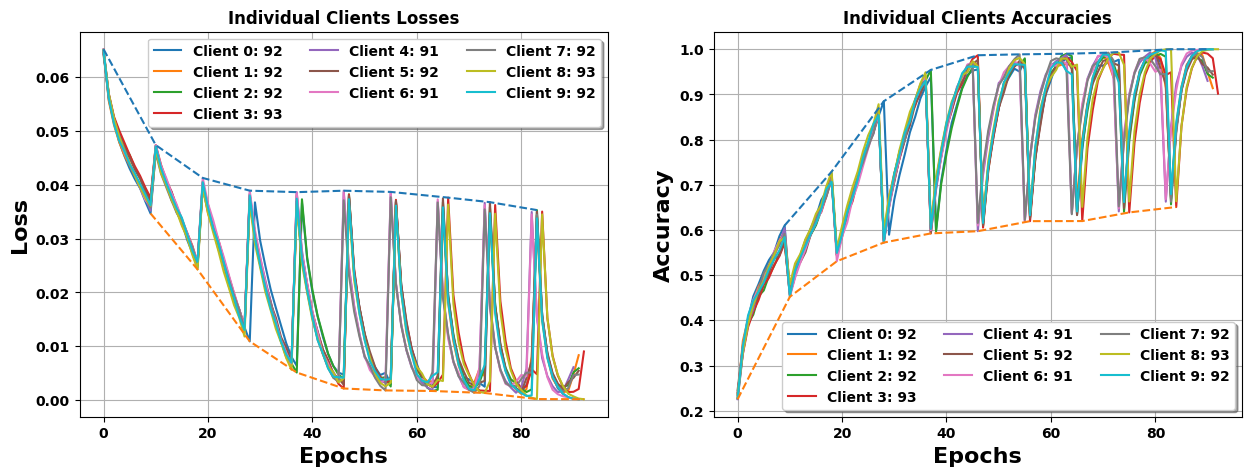

In [31]:
plot_metrics(plots)

Seperate Loss

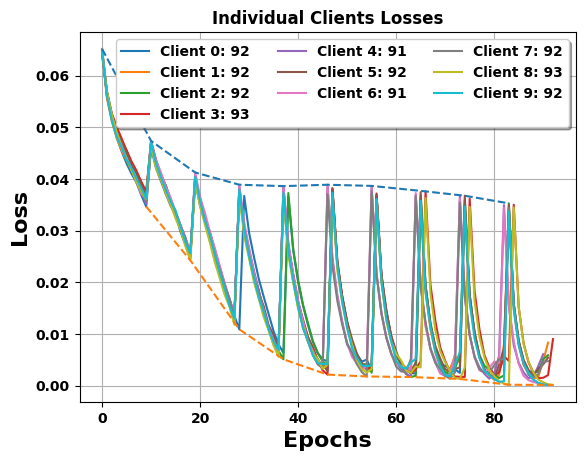

In [32]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.weight'] = 'bold'

def plot_metrics_loss(client_metrics, rounds: int = 10):
    # client_metrics = strategy.client_metrics
    client_ids = list(client_metrics.keys())
    client_ids.sort()
    axs = plt
   


    #fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    round_max_losses: List[Tuple[int, float]] = []
    round_max_accuracy: List[Tuple[int, float]] = []
    round_min_losses: List[Tuple[int, float]] = []
    round_min_accuracy: List[Tuple[int, float]] = []
    
    

    for round in range(1, rounds+1):
        metrics_round = [(metrics.epoch, metrics.loss, metrics.accuracy) for metrics_list in client_metrics.values()
                       for metrics in metrics_list if metrics.round == round]
        if metrics_round:
            min_loss = min(metrics_round, key=lambda x: x[1])
            max_loss = max(metrics_round, key=lambda x: x[1])
            round_max_losses.append(max_loss)
            round_min_losses.append(min_loss)
            min_accuracy = min(metrics_round, key=lambda x: x[2])
            max_accuracy = max(metrics_round, key=lambda x: x[2])
            round_max_accuracy.append(max_accuracy)
            round_min_accuracy.append(min_accuracy)

    for cid in client_ids:
        epochs = [metric.epoch for metric in client_metrics[cid]]
        losses = [metric.loss for metric in client_metrics[cid]]
        axs.plot(epochs, losses,label=f"Client {cid}: {len(strategy.client_metrics[cid])}")

    max_epochs = [round_max[0] for round_max in round_max_losses]
    max_losses = [round_max[1] for round_max in round_max_losses]
    min_epochs = [round_min[0] for round_min in round_min_losses]
    min_losses = [round_min[1] for round_min in round_min_losses]
    
    axs.plot(max_epochs, max_losses, linestyle='dashed')
    axs.plot(min_epochs, min_losses, linestyle='dashed')
    axs.title("Individual Clients Losses",weight='bold')
    axs.xlabel("Epochs", fontsize=16,weight='bold')
    axs.ylabel("Loss",fontsize=16,weight='bold')
    axs.legend(loc='upper right', shadow=True,ncol=3)
    axs.grid()
    


plot_metrics_loss(strategy.client_metrics)

Accuracy Sperate

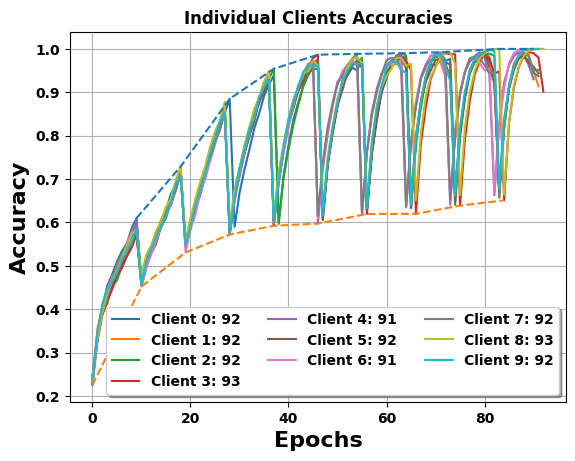

In [33]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.weight'] = 'bold'

def plot_metrics_acc(client_metrics, rounds: int = 10):
    # client_metrics = strategy.client_metrics
    client_ids = list(client_metrics.keys())
    client_ids.sort()
    axs = plt
   


    #fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    round_max_losses: List[Tuple[int, float]] = []
    round_max_accuracy: List[Tuple[int, float]] = []
    round_min_losses: List[Tuple[int, float]] = []
    round_min_accuracy: List[Tuple[int, float]] = []
    
    

    for round in range(1, rounds+1):
        metrics_round = [(metrics.epoch, metrics.loss, metrics.accuracy) for metrics_list in client_metrics.values()
                       for metrics in metrics_list if metrics.round == round]
        if metrics_round:
            min_loss = min(metrics_round, key=lambda x: x[1])
            max_loss = max(metrics_round, key=lambda x: x[1])
            round_max_losses.append(max_loss)
            round_min_losses.append(min_loss)
            min_accuracy = min(metrics_round, key=lambda x: x[2])
            max_accuracy = max(metrics_round, key=lambda x: x[2])
            round_max_accuracy.append(max_accuracy)
            round_min_accuracy.append(min_accuracy)

   


    for cid in client_ids:
        epochs = [metric.epoch for metric in client_metrics[cid]]
        accuracies = [metric.accuracy for metric in client_metrics[cid]]
        axs.plot(epochs, accuracies, label=f"Client {cid}: {len(client_metrics[cid])}")

    max_epochs = [round_max[0] for round_max in round_max_accuracy]
    max_accuracies = [round_max[2] for round_max in round_max_accuracy]
    min_epochs = [round_min[0] for round_min in round_min_accuracy]
    min_accuracies = [round_min[2] for round_min in round_min_accuracy]
    
    axs.plot(max_epochs, max_accuracies, linestyle='dashed')
    axs.plot(min_epochs, min_accuracies, linestyle='dashed')
    axs.title("Individual Clients Accuracies",weight='bold')

    axs.xlabel("Epochs", fontsize=16,weight='bold')
    axs.ylabel("Accuracy",fontsize=16,weight='bold')
    axs.legend(loc='lower right', shadow=True, ncol=3,fontsize=10)
    axs.grid()

    plt.show()

plot_metrics_acc(strategy.client_metrics)

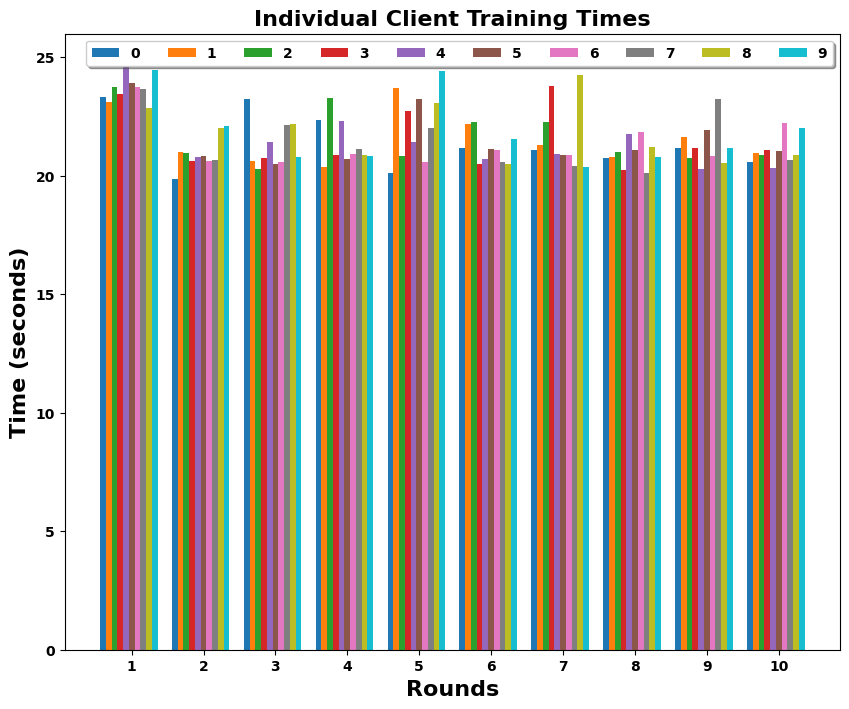

In [34]:
def plot_times(client_training_times):
    client_ids = list(client_training_times.keys())
    client_ids.sort()
    num_rounds = len(client_training_times[client_ids[0]])

    x = np.arange(num_rounds)  # Positions of the bars
    bar_width = 0.08 # Width of bars
    fig, ax = plt.subplots(figsize=(10, 8))

    for i, client_id in enumerate(client_ids):
        times = client_training_times[client_id]
        ax.bar(x + i * bar_width, times, bar_width, label=client_id)

    ax.set_xlabel("Rounds",fontsize=16,weight='bold')
    ax.set_ylabel("Time (seconds)",fontsize=16,weight='bold')
    ax.set_title("Individual Client Training Times",fontsize=16,weight='bold')
    ax.set_xticks(x + bar_width * round(len(client_ids) / 2))
    ax.set_xticklabels(np.arange(1, num_rounds + 1))
    ax.legend(loc='upper right', shadow=True, ncol=len(client_ids))

    plt.show()

plot_times(strategy.client_training_times)

In [35]:
for a in strategy.client_metrics:
    print(f"Client {a} metrics: {len(strategy.client_metrics[a])}")

Client 5 metrics: 92
Client 9 metrics: 92
Client 1 metrics: 92
Client 4 metrics: 91
Client 7 metrics: 92
Client 0 metrics: 92
Client 3 metrics: 93
Client 6 metrics: 91
Client 2 metrics: 92
Client 8 metrics: 93


# FedAvg

In [36]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.cid}] fit, config: {config}")
        set_parameters(self.net, parameters)
        start_time = time.time()  # Start time measurement
        metrics = train(self.net, self.trainloader, epochs=10)
        training_time = time.time() - start_time  # Calculate duration
        return get_parameters(self.net), len(self.trainloader), {"training_time": training_time, "metrics": json.dumps(metrics)}

    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        print(f"Client {self.cid} loss {loss}")
        print(f"Client {self.cid} accuracy {accuracy}")
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(cid) -> FlowerClient:
    net = Net().to(DEVICE) #Load Model from here
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FlowerClient(cid, net, trainloader, valloader).to_client()

In [37]:
class FedAvgCustom(fl.server.strategy.FedAvg):
    def __init__(
        self,
        fraction_fit = 1.0,
        fraction_evaluate = 1.0,
        min_fit_clients = 2,
        min_evaluate_clients = 2,
        min_available_clients = 2,
    ):
        super().__init__(fraction_fit = fraction_fit, fraction_evaluate = fraction_evaluate, min_fit_clients = min_fit_clients, min_evaluate_clients = min_evaluate_clients, min_available_clients = min_available_clients)
        self.client_training_times: Dict[int, List[float]] = {}
        self.client_metrics: Dict[int, List[ClientMetrics]] = {}
        self.loss_extreme: Dict[int, Tuple[int, float, float]] = {}
        self.accuracy_extreme: Dict[int, Tuple[int, float, float]] = {}

    def parse_metrics(self, cid: int, server_round: int, metrics: str):
        client_data: List[ClientMetrics] = json.loads(metrics)
        data_store: List[ClientMetrics] = self.client_metrics.setdefault(cid, [])
        last_epoch: int = len(data_store)
        for data in client_data:
            data_store.append(ClientMetrics(last_epoch, data[1], data[2], round=server_round, cid=cid))
            last_epoch += 1

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        for client, fit_res in results:
            self.client_training_times.setdefault(client.cid, []).append(fit_res.metrics.get("training_time", 0))
            self.parse_metrics(client.cid, server_round, fit_res.metrics.get("metrics", None))
        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        metrics_aggregated = {}
        return parameters_aggregated, metrics_aggregated



In [38]:
class FedProxCustom(fl.server.strategy.FedProx):
    def __init__(
        self,
        fraction_fit = 1.0,
        fraction_evaluate = 1.0,
        min_fit_clients = 2,
        min_evaluate_clients = 2,
        min_available_clients = 2,
        proximal_mu=1.0,
    ):
        super().__init__(fraction_fit = fraction_fit, fraction_evaluate = fraction_evaluate, min_fit_clients = min_fit_clients, min_evaluate_clients = min_evaluate_clients, min_available_clients = min_available_clients,proximal_mu=proximal_mu)
        self.client_training_times: Dict[int, List[float]] = {}
        self.client_metrics: Dict[int, List[ClientMetrics]] = {}
        self.loss_extreme: Dict[int, Tuple[int, float, float]] = {}
        self.accuracy_extreme: Dict[int, Tuple[int, float, float]] = {}

    def parse_metrics(self, cid: int, server_round: int, metrics: str):
        client_data: List[ClientMetrics] = json.loads(metrics)
        data_store: List[ClientMetrics] = self.client_metrics.setdefault(cid, [])
        last_epoch: int = len(data_store)
        for data in client_data:
            data_store.append(ClientMetrics(last_epoch, data[1], data[2], round=server_round, cid=cid))
            last_epoch += 1

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        for client, fit_res in results:
            self.client_training_times.setdefault(client.cid, []).append(fit_res.metrics.get("training_time", 0))
            self.parse_metrics(client.cid, server_round, fit_res.metrics.get("metrics", None))
        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        metrics_aggregated = {}
        return parameters_aggregated, metrics_aggregated



In [39]:
#from flwr.server.strategy import FedProx

In [40]:
#strategy_fed_avg = FedAvgCustom()
#strategy_fed_prox = fl.server.strategy.FedProx(proximal_mu=1.0)
strategy_fed_prox = FedProxCustom()

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=10,
    config=fl.server.ServerConfig(num_rounds=10),
    client_resources=client_resources,
    strategy= strategy_fed_prox,
)

INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
2024-12-15 12:08:21,358	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 32.0, 'object_store_memory': 33033623961.0, 'accelerator_type:RTX': 1.0, 'memory': 67078455911.0, 'GPU': 1.0, 'node:127.0.0.1': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_gpus': 0.125, 'num_cpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 8 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
INFO :      Received initial parameters from one random client
INFO :      Evaluating initial global parameters
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=44048) [Client 2] get_parameters
(ClientAppActor pid=44048) [Client 4] fit, config: {'proximal_mu': 1.0}
(ClientAppActor pid=44048) Epoch 0: train loss 0.064296, accuracy 0.230444
(ClientAppActor pid=44048) Epoch 1: train loss 0.055463, accuracy 0.355111
(ClientAppActor pid=47220) [Client 0] fit, config: {'proximal_mu': 1.0}
(ClientAppActor pid=44048) Epoch 2: train loss 0.051027, accuracy 0.403111
(ClientAppActor pid=47220) Epoch 0: train loss 0.064038, accuracy 0.234222
(ClientAppActor pid=51304) [Client 9] fit, config: {'proximal_mu': 1.0} [repeated 3x across cluster]
(ClientAppActor pid=18292) Epoch 0: train loss 0.064294, accuracy 0.236667 [repeated 10x across cluster]
(ClientAppActor pid=28864) [Client 7] fit, config: {'proximal_mu': 1.0} [repeated 3x across cluster]
(ClientAppActor pid=44048) Epoch 7: train loss 0.040070, accuracy 0.539778 [repeated 18x across cluster]
(ClientAppActor pid=44048) Epoch 9: train loss 0.037309, accuracy 0.567556 [repeated 16x ac

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=47220) Epoch 9: train loss 0.038094, accuracy 0.549111 [repeated 4x across cluster]
(ClientAppActor pid=47220) [Client 6] evaluate, config: {}
(ClientAppActor pid=47220) Client 6 loss 0.05583321928977966
(ClientAppActor pid=47220) Client 6 accuracy 0.38
(ClientAppActor pid=18292) [Client 2] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=47220) Client 7 loss 0.05613708734512329 [repeated 4x across cluster]
(ClientAppActor pid=47220) Client 7 accuracy 0.356 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=47220) [Client 1] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=47220) Client 1 loss 0.05641875433921814 [repeated 5x across cluster]
(ClientAppActor pid=47220) Client 1 accuracy 0.392 [repeated 5x across cluster]
(ClientAppActor pid=47220) [Client 7] fit, config: {'proximal_mu': 1.0}
(ClientAppActor pid=47220) Epoch 0: train loss 0.046740, accuracy 0.468444
(ClientAppActor pid=44048) [Client 2] fit, config: {'proximal_mu': 1.0} [repeated 3x across cluster]
(ClientAppActor pid=28864) Epoch 0: train loss 0.048563, accuracy 0.436444 [repeated 10x across cluster]
(ClientAppActor pid=41304) [Client 5] fit, config: {'proximal_mu': 1.0} [repeated 4x across cluster]
(ClientAppActor pid=18292) Epoch 3: train loss 0.039979, accuracy 0.541333 [repeated 18x across cluster]
(ClientAppActor pid=28864) Epoch 5: train loss 0.035606, accuracy 0.591111 [repeated 20x across cluster]
(ClientAppActor pid=47220) [Client 0] fit, config: {'proximal_mu': 1.0}
(Clien

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=46652) [Client 7] evaluate, config: {}
(ClientAppActor pid=46652) Epoch 9: train loss 0.023929, accuracy 0.729111 [repeated 2x across cluster]
(ClientAppActor pid=46652) Client 7 loss 0.04185255467891693
(ClientAppActor pid=46652) Client 7 accuracy 0.564
(ClientAppActor pid=51304) [Client 0] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=51304) Client 0 loss 0.045990532159805295 [repeated 4x across cluster]
(ClientAppActor pid=51304) Client 0 accuracy 0.504 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=47220) [Client 3] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=47220) Client 3 loss 0.045870930194854734 [repeated 5x across cluster]
(ClientAppActor pid=47220) Client 3 accuracy 0.534 [repeated 5x across cluster]
(ClientAppActor pid=47220) [Client 5] fit, config: {'proximal_mu': 1.0}
(ClientAppActor pid=47220) Epoch 0: train loss 0.041239, accuracy 0.528889
(ClientAppActor pid=28864) [Client 9] fit, config: {'proximal_mu': 1.0} [repeated 4x across cluster]
(ClientAppActor pid=46652) Epoch 1: train loss 0.035227, accuracy 0.589778 [repeated 8x across cluster]
(ClientAppActor pid=51796) [Client 8] fit, config: {'proximal_mu': 1.0} [repeated 3x across cluster]
(ClientAppActor pid=28864) Epoch 3: train loss 0.028605, accuracy 0.676222 [repeated 20x across cluster]
(ClientAppActor pid=18292) Epoch 5: train loss 0.024221, accuracy 0.734444 [repeated 20x across cluster]
(ClientAppActor pid=47220) [Client 3] fit, config: {'proximal_mu': 1.0}
(Clien

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=41304) [Client 5] evaluate, config: {}
(ClientAppActor pid=41304) Client 5 loss 0.04409209418296814
(ClientAppActor pid=41304) Client 5 accuracy 0.588
(ClientAppActor pid=41304) Epoch 9: train loss 0.011382, accuracy 0.874667 [repeated 2x across cluster]
(ClientAppActor pid=28864) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=18292) Client 8 loss 0.049184034943580625 [repeated 4x across cluster]
(ClientAppActor pid=18292) Client 8 accuracy 0.554 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=51796) [Client 4] fit, config: {'proximal_mu': 1.0}
(ClientAppActor pid=51796) [Client 2] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=51796) Client 2 loss 0.054471067905426024 [repeated 5x across cluster]
(ClientAppActor pid=51796) Client 2 accuracy 0.51 [repeated 5x across cluster]
(ClientAppActor pid=51796) Epoch 0: train loss 0.038577, accuracy 0.577778
(ClientAppActor pid=46652) [Client 5] fit, config: {'proximal_mu': 1.0} [repeated 3x across cluster]
(ClientAppActor pid=18292) Epoch 0: train loss 0.037795, accuracy 0.583111 [repeated 10x across cluster]
(ClientAppActor pid=47220) [Client 2] fit, config: {'proximal_mu': 1.0} [repeated 4x across cluster]
(ClientAppActor pid=41304) Epoch 4: train loss 0.018719, accuracy 0.796000 [repeated 18x across cluster]
(ClientAppActor pid=28864) Epoch 4: train loss 0.017857, accuracy 0.807778 [repeated 18x across cluster]
(ClientAppActor pid=51796) Epoch 9: train loss 0.005322, accuracy 0.952000 [re

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=44048) [Client 4] evaluate, config: {}
(ClientAppActor pid=44048) Epoch 9: train loss 0.005236, accuracy 0.951556 [repeated 3x across cluster]
(ClientAppActor pid=44048) Client 4 loss 0.05772203421592712
(ClientAppActor pid=44048) Client 4 accuracy 0.5
(ClientAppActor pid=44048) [Client 7] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=44048) Client 7 loss 0.054763640642166135 [repeated 4x across cluster]
(ClientAppActor pid=44048) Client 7 accuracy 0.568 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=51796) [Client 0] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=46652) Client 8 loss 0.05670711612701416 [repeated 4x across cluster]
(ClientAppActor pid=46652) Client 8 accuracy 0.562 [repeated 4x across cluster]
(ClientAppActor pid=51796) [Client 5] fit, config: {'proximal_mu': 1.0}
(ClientAppActor pid=51796) Client 0 loss 0.059358163356781006
(ClientAppActor pid=51796) Client 0 accuracy 0.548
(ClientAppActor pid=51796) Epoch 0: train loss 0.038670, accuracy 0.582889
(ClientAppActor pid=28864) [Client 0] fit, config: {'proximal_mu': 1.0} [repeated 4x across cluster]
(ClientAppActor pid=28864) Epoch 0: train loss 0.037816, accuracy 0.604889 [repeated 8x across cluster]
(ClientAppActor pid=41304) [Client 9] fit, config: {'proximal_mu': 1.0} [repeated 3x across cluster]
(ClientAppActor pid=46652) Epoch 4: train loss 0.012713, accuracy 0.868667 [repeated 20x across cluster]
(ClientAppActor pid=41304) Epoch 4: train loss 0.012277, accuracy 0.872

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=51304) [Client 1] evaluate, config: {}
(ClientAppActor pid=51304) Epoch 9: train loss 0.001844, accuracy 0.989778 [repeated 3x across cluster]
(ClientAppActor pid=51304) Client 1 loss 0.07190396070480347
(ClientAppActor pid=51304) Client 1 accuracy 0.51
(ClientAppActor pid=44048) [Client 3] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=44048) Client 3 loss 0.0693442828655243 [repeated 4x across cluster]
(ClientAppActor pid=44048) Client 3 accuracy 0.57 [repeated 4x across cluster]
(ClientAppActor pid=46652) [Client 5] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=46652) Client 5 loss 0.058431745767593385 [repeated 4x across cluster]
(ClientAppActor pid=46652) Client 5 accuracy 0.602 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=41304) [Client 0] fit, config: {'proximal_mu': 1.0}
(ClientAppActor pid=41304) [Client 4] evaluate, config: {}
(ClientAppActor pid=41304) Client 4 loss 0.06476443839073182
(ClientAppActor pid=41304) Client 4 accuracy 0.518
(ClientAppActor pid=41304) Epoch 0: train loss 0.036915, accuracy 0.618889
(ClientAppActor pid=28864) [Client 8] fit, config: {'proximal_mu': 1.0} [repeated 4x across cluster]
(ClientAppActor pid=51796) Epoch 0: train loss 0.039002, accuracy 0.593556 [repeated 12x across cluster]
(ClientAppActor pid=18292) [Client 9] fit, config: {'proximal_mu': 1.0} [repeated 3x across cluster]
(ClientAppActor pid=44048) Epoch 4: train loss 0.008996, accuracy 0.915778 [repeated 20x across cluster]
(ClientAppActor pid=47220) Epoch 5: train loss 0.006701, accuracy 0.933333 [repeated 19x across cluster]
(ClientAppActor pid=41304) [Client 6] fit, config: {'proximal_mu': 1.0}
(ClientAppActor pid=47220) Epoch 7: train loss 0.004423, accuracy 0.959556 [repeated 16x acro

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=46652) Epoch 9: train loss 0.002735, accuracy 0.979556 [repeated 4x across cluster]
(ClientAppActor pid=46652) [Client 1] evaluate, config: {}
(ClientAppActor pid=46652) Client 1 loss 0.07713665318489074
(ClientAppActor pid=46652) Client 1 accuracy 0.5
(ClientAppActor pid=47220) [Client 2] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=41304) Client 5 loss 0.06076747536659241 [repeated 4x across cluster]
(ClientAppActor pid=41304) Client 5 accuracy 0.59 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=51796) [Client 3] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=51796) Client 3 loss 0.07560702323913575 [repeated 5x across cluster]
(ClientAppActor pid=51796) Client 3 accuracy 0.54 [repeated 5x across cluster]
(ClientAppActor pid=51796) [Client 7] fit, config: {'proximal_mu': 1.0}
(ClientAppActor pid=51796) Epoch 0: train loss 0.039322, accuracy 0.606889
(ClientAppActor pid=46652) [Client 0] fit, config: {'proximal_mu': 1.0} [repeated 3x across cluster]
(ClientAppActor pid=28864) Epoch 0: train loss 0.039193, accuracy 0.600667 [repeated 11x across cluster]
(ClientAppActor pid=51304) [Client 2] fit, config: {'proximal_mu': 1.0} [repeated 4x across cluster]
(ClientAppActor pid=44048) Epoch 2: train loss 0.014650, accuracy 0.833111 [repeated 18x across cluster]
(ClientAppActor pid=18292) Epoch 6: train loss 0.003799, accuracy 0.967778 [repeated 18x across cluster]
(ClientAppActor pid=51796) [Client 8] fit, config: {'proximal_mu': 1.0}
(Client

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=41304) [Client 9] evaluate, config: {}
(ClientAppActor pid=41304) Client 9 loss 0.06972892045974731
(ClientAppActor pid=41304) Client 9 accuracy 0.55
(ClientAppActor pid=41304) Epoch 9: train loss 0.003211, accuracy 0.969333 [repeated 2x across cluster]
(ClientAppActor pid=51304) [Client 4] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=51304) Client 4 loss 0.07237794017791747 [repeated 4x across cluster]
(ClientAppActor pid=51304) Client 4 accuracy 0.52 [repeated 4x across cluster]
(ClientAppActor pid=41304) [Client 2] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=41304) Client 2 loss 0.07405459809303283 [repeated 4x across cluster]
(ClientAppActor pid=41304) Client 2 accuracy 0.548 [repeated 4x across cluster]
(ClientAppActor pid=46652) [Client 2] fit, config: {'proximal_mu': 1.0}
(ClientAppActor pid=46652) [Client 1] evaluate, config: {}
(ClientAppActor pid=46652) Epoch 0: train loss 0.037248, accuracy 0.632444
(ClientAppActor pid=46652) Client 1 loss 0.07978733730316162
(ClientAppActor pid=46652) Client 1 accuracy 0.508
(ClientAppActor pid=47220) [Client 1] fit, config: {'proximal_mu': 1.0} [repeated 4x across cluster]
(ClientAppActor pid=47220) Epoch 0: train loss 0.037990, accuracy 0.628889 [repeated 7x across cluster]
(ClientAppActor pid=18292) [Client 0] fit, config: {'proximal_mu': 1.0} [repeated 3x across cluster]
(ClientAppActor pid=47220) Epoch 3: train loss 0.007652, accuracy 0.928444 [repeated 21x across cluster]
(ClientAppActor pid=46652) Epoch 7: train loss 0.003028, accuracy 0.972000 [repeated 19x across clust

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=28864) [Client 2] evaluate, config: {}
(ClientAppActor pid=28864) Client 2 loss 0.07647492384910584
(ClientAppActor pid=28864) Client 2 accuracy 0.546
(ClientAppActor pid=28864) Epoch 9: train loss 0.005315, accuracy 0.945333 [repeated 2x across cluster]
(ClientAppActor pid=51796) [Client 3] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=51796) Client 3 loss 0.08162931156158447 [repeated 4x across cluster]
(ClientAppActor pid=51796) Client 3 accuracy 0.528 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=18292) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=18292) Client 1 loss 0.07956256794929505 [repeated 5x across cluster]
(ClientAppActor pid=18292) Client 1 accuracy 0.52 [repeated 5x across cluster]
(ClientAppActor pid=18292) [Client 9] fit, config: {'proximal_mu': 1.0}
(ClientAppActor pid=18292) Epoch 0: train loss 0.036022, accuracy 0.635556
(ClientAppActor pid=46652) [Client 0] fit, config: {'proximal_mu': 1.0} [repeated 4x across cluster]
(ClientAppActor pid=47220) Epoch 1: train loss 0.018146, accuracy 0.797111 [repeated 11x across cluster]
(ClientAppActor pid=28864) [Client 8] fit, config: {'proximal_mu': 1.0} [repeated 3x across cluster]
(ClientAppActor pid=51796) Epoch 2: train loss 0.010439, accuracy 0.895333 [repeated 17x across cluster]
(ClientAppActor pid=41304) Epoch 7: train loss 0.000622, accuracy 0.998000 [repeated 20x across cluster]
(ClientAppActor pid=18292) Epoch 9: train loss 0.006107, accuracy 0.936000 [rep

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=41304) [Client 4] evaluate, config: {}
(ClientAppActor pid=41304) Epoch 9: train loss 0.008567, accuracy 0.907778 [repeated 3x across cluster]
(ClientAppActor pid=41304) Client 4 loss 0.07649756360054016
(ClientAppActor pid=41304) Client 4 accuracy 0.51
(ClientAppActor pid=46652) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=51304) Client 0 loss 0.07651224279403687 [repeated 4x across cluster]
(ClientAppActor pid=51304) Client 0 accuracy 0.544 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=18292) [Client 3] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=18292) Client 3 loss 0.08387314701080323 [repeated 5x across cluster]
(ClientAppActor pid=18292) Client 3 accuracy 0.518 [repeated 5x across cluster]
(ClientAppActor pid=18292) [Client 1] fit, config: {'proximal_mu': 1.0}
(ClientAppActor pid=18292) Epoch 0: train loss 0.035844, accuracy 0.659111
(ClientAppActor pid=28864) [Client 7] fit, config: {'proximal_mu': 1.0} [repeated 3x across cluster]
(ClientAppActor pid=44048) Epoch 0: train loss 0.034272, accuracy 0.656222 [repeated 7x across cluster]
(ClientAppActor pid=51304) [Client 3] fit, config: {'proximal_mu': 1.0} [repeated 4x across cluster]
(ClientAppActor pid=51796) Epoch 4: train loss 0.002635, accuracy 0.983111 [repeated 21x across cluster]
(ClientAppActor pid=44048) Epoch 5: train loss 0.001524, accuracy 0.993333 [repeated 17x across cluster]
(ClientAppActor pid=18292) Epoch 9: train loss 0.000119, accuracy 1.000000 [rep

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=41304) [Client 6] evaluate, config: {}
(ClientAppActor pid=41304) Epoch 9: train loss 0.007183, accuracy 0.921111 [repeated 3x across cluster]
(ClientAppActor pid=41304) Client 6 loss 0.09095757293701172
(ClientAppActor pid=41304) Client 6 accuracy 0.56
(ClientAppActor pid=46652) [Client 8] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=47220) Client 2 loss 0.08984588813781738 [repeated 4x across cluster]
(ClientAppActor pid=47220) Client 2 accuracy 0.55 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 653.80s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.05603117048740387
INFO :      		round 2: 0.04462810761928558
INFO :      		round 3: 0.0504917917251587
INFO :      		round 4: 0.05875106389522552
INFO :      		round 5: 0.06571052310466766
INFO :      		round 6: 0.06998528687953949
INFO :      		round 7: 0.07235474984645843
INFO :      		round 8: 0.07385276701450347
INFO :      		round 9: 0.07442664091587067
INFO :      		round 10: 0.08697367327213287
INFO :      


History (loss, distributed):
	round 1: 0.05603117048740387
	round 2: 0.04462810761928558
	round 3: 0.0504917917251587
	round 4: 0.05875106389522552
	round 5: 0.06571052310466766
	round 6: 0.06998528687953949
	round 7: 0.07235474984645843
	round 8: 0.07385276701450347
	round 9: 0.07442664091587067
	round 10: 0.08697367327213287

In [41]:
def save_data_prox(client_metrics, rounds: int = 10):
    with open("data_fedprox.json", "w") as data:
        data.write(json.dumps(client_metrics))
save_data_prox(strategy_fed_prox.client_metrics)

(ClientAppActor pid=41304) Client 7 loss 0.0792367765903473
(ClientAppActor pid=41304) Client 7 accuracy 0.556


In [42]:
import matplotlib.pyplot as plt


def plot_metricss(client_metrics, rounds: int = 10):
    # client_metrics = strategy.client_metrics
    client_ids = list(client_metrics.keys())
    client_ids.sort()

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    round_max_losses: List[Tuple[int, float]] = []
    round_max_accuracy: List[Tuple[int, float]] = []
    round_min_losses: List[Tuple[int, float]] = []
    round_min_accuracy: List[Tuple[int, float]] = []

    for round in range(1, rounds+1):
        metrics_round = [(metrics.epoch, metrics.loss, metrics.accuracy) for metrics_list in client_metrics.values()
                       for metrics in metrics_list if metrics.round == round]
        if metrics_round:
            min_loss = min(metrics_round, key=lambda x: x[1])
            max_loss = max(metrics_round, key=lambda x: x[1])
            round_max_losses.append(max_loss)
            round_min_losses.append(min_loss)
            min_accuracy = min(metrics_round, key=lambda x: x[2])
            max_accuracy = max(metrics_round, key=lambda x: x[2])
            round_max_accuracy.append(max_accuracy)
            round_min_accuracy.append(min_accuracy)

    for cid in client_ids:
        epochs = [metric.epoch for metric in client_metrics[cid]]
        losses = [metric.loss for metric in client_metrics[cid]]
        axs[0].plot(epochs, losses,label=f"Client {cid}: {len(strategy_fed_prox.client_metrics[cid])}")

    max_epochs = [round_max[0] for round_max in round_max_losses]
    max_losses = [round_max[1] for round_max in round_max_losses]
    min_epochs = [round_min[0] for round_min in round_min_losses]
    min_losses = [round_min[1] for round_min in round_min_losses]
    axs[0].plot(max_epochs, max_losses, linestyle='dashed')
    axs[0].plot(min_epochs, min_losses, linestyle='dashed')
    axs[0].set_title("Individual Clients Losses",weight='bold')
    axs[0].set_xlabel("Epochs", fontsize=16,weight='bold')
    axs[0].set_ylabel("Loss",fontsize=16,weight='bold')
    axs[0].legend(loc='upper right', shadow=True,ncol=3)
    axs[0].grid()
    


    for cid in client_ids:
        epochs = [metric.epoch for metric in client_metrics[cid]]
        accuracies = [metric.accuracy for metric in client_metrics[cid]]
        axs[1].plot(epochs, accuracies, label=f"Client {cid}: {len(client_metrics[cid])}")

    max_epochs = [round_max[0] for round_max in round_max_accuracy]
    max_accuracies = [round_max[2] for round_max in round_max_accuracy]
    min_epochs = [round_min[0] for round_min in round_min_accuracy]
    min_accuracies = [round_min[2] for round_min in round_min_accuracy]
    
    axs[1].plot(max_epochs, max_accuracies, linestyle='dashed')
    axs[1].plot(min_epochs, min_accuracies, linestyle='dashed')
    axs[1].set_title("Individual Clients Accuracies",weight='bold')

    axs[1].set_xlabel("Epochs", fontsize=16,weight='bold')
    axs[1].set_ylabel("Accuracy",fontsize=16,weight='bold')
    axs[1].legend(loc='lower right', shadow=True, ncol=3,fontsize=10)
    axs[1].grid()

    plt.show()
#plot_metrics(strategy.client_metrics)

In [43]:
plots = load_data("data_fedprox.json")

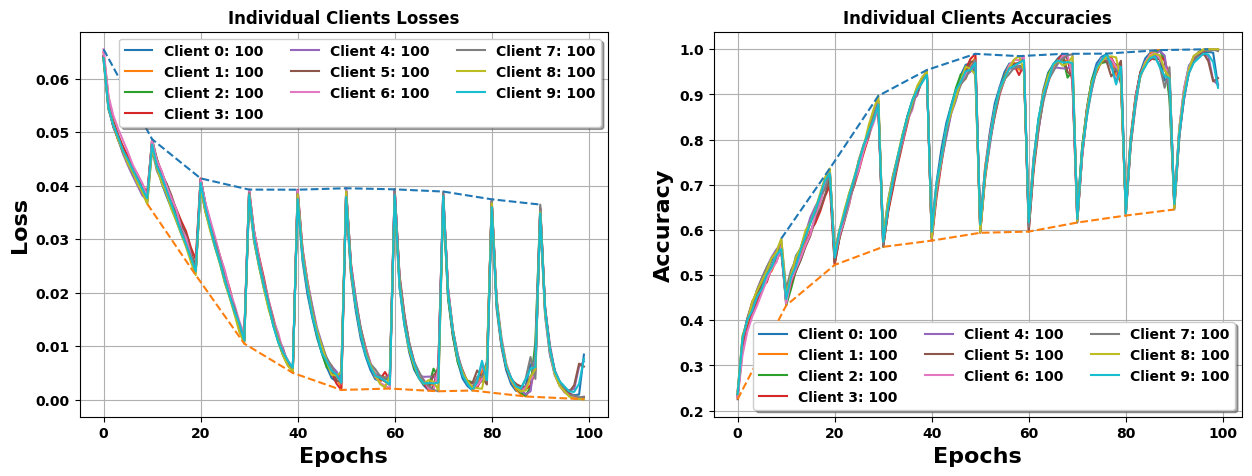

In [44]:
plot_metricss(strategy_fed_prox.client_metrics)


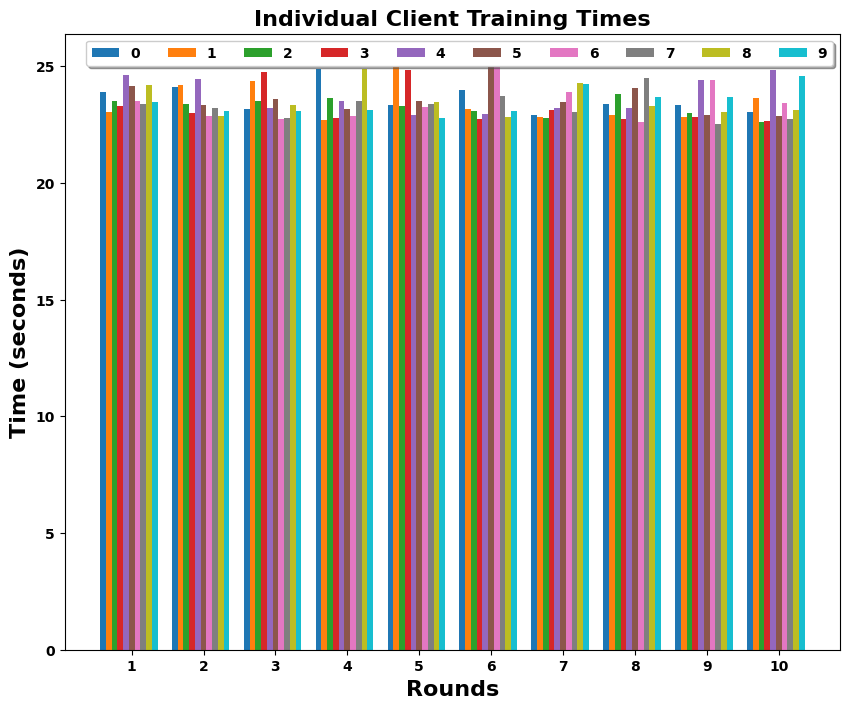

In [45]:
plot_times(strategy_fed_prox.client_training_times)

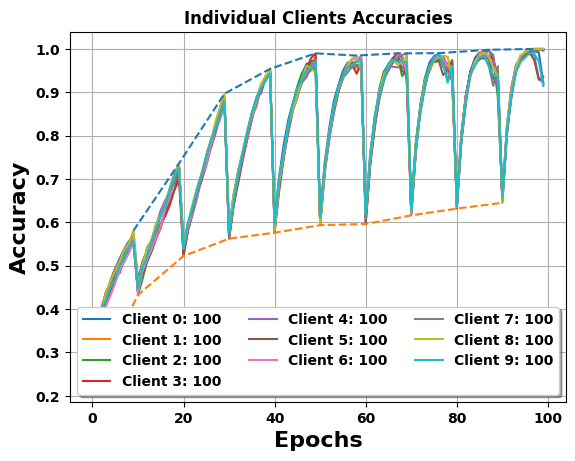

In [52]:
plot_metrics_acc(strategy_fed_prox.client_metrics)

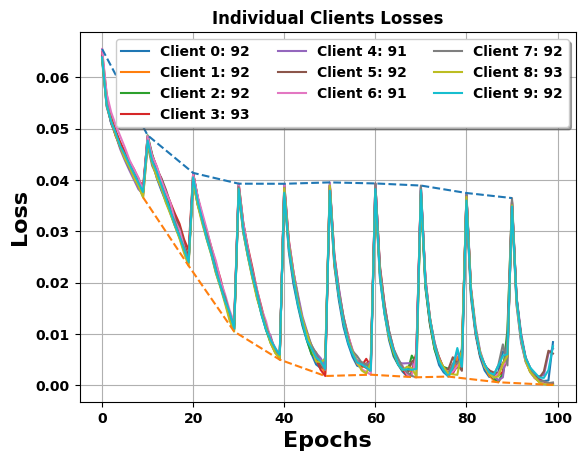

In [53]:
plot_metrics_loss(strategy_fed_prox.client_metrics)

In [51]:
strategy_fed_avg = FedAvgCustom()

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=10,
    config=fl.server.ServerConfig(num_rounds=10),
    client_resources=client_resources,
    strategy=strategy_fed_avg,
)

INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
2024-12-15 12:32:44,650	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 32.0, 'object_store_memory': 33044028211.0, 'node:127.0.0.1': 1.0, 'memory': 67102732493.0, 'GPU': 1.0, 'accelerator_type:RTX': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_gpus': 0.125, 'num_cpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 8 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
INFO :      Received initial parameters from one random client
INFO :      Evaluating initial global parameters
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=49236) [Client 1] get_parameters
(ClientAppActor pid=49236) [Client 9] fit, config: {}
(ClientAppActor pid=49236) Epoch 0: train loss 0.065489, accuracy 0.228667
(ClientAppActor pid=49236) Epoch 1: train loss 0.057350, accuracy 0.322889
(ClientAppActor pid=34504) [Client 2] fit, config: {}
(ClientAppActor pid=49236) Epoch 2: train loss 0.052602, accuracy 0.385778
(ClientAppActor pid=34504) Epoch 0: train loss 0.065019, accuracy 0.224222
(ClientAppActor pid=51472) [Client 7] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=49236) Epoch 5: train loss 0.045882, accuracy 0.467111 [repeated 11x across cluster]
(ClientAppActor pid=31636) [Client 0] fit, config: {}
(ClientAppActor pid=37796) Epoch 3: train loss 0.049028, accuracy 0.427333 [repeated 17x across cluster]
(ClientAppActor pid=49236) Epoch 9: train loss 0.038262, accuracy 0.549111 [repeated 14x across cluster]
(ClientAppActor pid=49236) [Client 5] fit, config: {}
(ClientAppActor pid=49236) Epoch 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=34504) Epoch 9: train loss 0.036037, accuracy 0.578444 [repeated 3x across cluster]
(ClientAppActor pid=34504) [Client 8] evaluate, config: {}
(ClientAppActor pid=34504) Client 8 loss 0.052547646045684814
(ClientAppActor pid=34504) Client 8 accuracy 0.38
(ClientAppActor pid=34504) [Client 0] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=34504) Client 0 loss 0.05399346661567688 [repeated 4x across cluster]
(ClientAppActor pid=34504) Client 0 accuracy 0.402 [repeated 4x across cluster]
(ClientAppActor pid=34504) [Client 7] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=34504) Client 7 loss 0.052678851127624514 [repeated 4x across cluster]
(ClientAppActor pid=34504) Client 7 accuracy 0.392 [repeated 4x across cluster]
(ClientAppActor pid=37796) [Client 1] fit, config: {}
(ClientAppActor pid=37796) [Client 4] evaluate, config: {}
(ClientAppActor pid=37796) Client 4 loss 0.05273220181465149
(ClientAppActor pid=37796) Client 4 accuracy 0.402
(ClientAppActor pid=37796) Epoch 0: train loss 0.046391, accuracy 0.472667
(ClientAppActor pid=51472) [Client 8] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=37796) Epoch 2: train loss 0.039568, accuracy 0.546667 [repeated 8x across cluster]
(ClientAppActor pid=51944) [Client 3] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=38652) Epoch 3: train loss 0.038045, accuracy 0.560667 [repeated 20x across cluster]
(ClientAppActor pid=50160) Epoch 4: train loss 0.035127, accuracy 0.596667 [repeated 19x across cluster]
(ClientAppActor pid=37796) Epoch 9: train loss 0.

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=34504) [Client 9] evaluate, config: {}
(ClientAppActor pid=34504) Client 9 loss 0.04513131356239319
(ClientAppActor pid=34504) Client 9 accuracy 0.526
(ClientAppActor pid=34504) Epoch 9: train loss 0.023348, accuracy 0.738444
(ClientAppActor pid=38652) [Client 2] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=49236) Client 7 loss 0.04160540103912354 [repeated 4x across cluster]
(ClientAppActor pid=49236) Client 7 accuracy 0.542 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=51944) [Client 0] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=51944) Client 0 loss 0.044665467023849485 [repeated 5x across cluster]
(ClientAppActor pid=51944) Client 0 accuracy 0.53 [repeated 5x across cluster]
(ClientAppActor pid=51944) [Client 1] fit, config: {}
(ClientAppActor pid=51944) Epoch 0: train loss 0.039120, accuracy 0.552444
(ClientAppActor pid=38652) [Client 0] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=38652) Epoch 0: train loss 0.039766, accuracy 0.541778 [repeated 8x across cluster]
(ClientAppActor pid=34504) [Client 5] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=31636) Epoch 4: train loss 0.024791, accuracy 0.716444 [repeated 20x across cluster]
(ClientAppActor pid=38652) Epoch 5: train loss 0.020435, accuracy 0.770444 [repeated 18x across cluster]
(ClientAppActor pid=51944) Epoch 9: train loss 0.009156, accuracy 0.904444 [repeated 15x across cluster]
(ClientAppActor pid=51944) [

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=51472) [Client 2] evaluate, config: {}
(ClientAppActor pid=51472) Client 2 loss 0.051740561127662656
(ClientAppActor pid=51472) Client 2 accuracy 0.544
(ClientAppActor pid=51472) Epoch 9: train loss 0.010198, accuracy 0.895333 [repeated 2x across cluster]
(ClientAppActor pid=37796) [Client 5] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=37796) Client 5 loss 0.047734771728515625 [repeated 4x across cluster]
(ClientAppActor pid=37796) Client 5 accuracy 0.588 [repeated 4x across cluster]
(ClientAppActor pid=51472) [Client 3] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=50160) [Client 7] fit, config: {}
(ClientAppActor pid=50160) Client 1 loss 0.05189229846000672 [repeated 5x across cluster]
(ClientAppActor pid=50160) Client 1 accuracy 0.568 [repeated 5x across cluster]
(ClientAppActor pid=50160) [Client 1] evaluate, config: {}
(ClientAppActor pid=50160) Epoch 0: train loss 0.038283, accuracy 0.583111
(ClientAppActor pid=49236) [Client 8] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=49236) Epoch 1: train loss 0.028968, accuracy 0.672222 [repeated 11x across cluster]
(ClientAppActor pid=31636) [Client 0] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=38652) Epoch 4: train loss 0.015980, accuracy 0.827111 [repeated 17x across cluster]
(ClientAppActor pid=51472) Epoch 7: train loss 0.007303, accuracy 0.927778 [repeated 20x across cluster]
(ClientAppActor pid=51944) Epoch 7: train loss 0.007830, accuracy 0.922222 [repeated 17x across cluster]
(ClientAppActor pid=50160) [Client 6] fit, config: {}
(C

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=51472) [Client 6] evaluate, config: {}
(ClientAppActor pid=51472) Client 6 loss 0.0580743842124939
(ClientAppActor pid=51472) Client 6 accuracy 0.572
(ClientAppActor pid=51472) Epoch 9: train loss 0.004533, accuracy 0.959556
(ClientAppActor pid=50160) [Client 4] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=51472) Client 0 loss 0.0613164963722229 [repeated 4x across cluster]
(ClientAppActor pid=51472) Client 0 accuracy 0.546 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=49236) [Client 2] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=49236) Client 2 loss 0.06024643266201019 [repeated 5x across cluster]
(ClientAppActor pid=49236) Client 2 accuracy 0.572 [repeated 5x across cluster]
(ClientAppActor pid=49236) [Client 7] fit, config: {}
(ClientAppActor pid=49236) Epoch 0: train loss 0.038740, accuracy 0.588444
(ClientAppActor pid=51944) [Client 5] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=49236) Epoch 2: train loss 0.019643, accuracy 0.781111 [repeated 8x across cluster]
(ClientAppActor pid=38652) [Client 9] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=49236) Epoch 5: train loss 0.008029, accuracy 0.920000 [repeated 20x across cluster]
(ClientAppActor pid=51944) Epoch 6: train loss 0.006350, accuracy 0.935778 [repeated 20x across cluster]
(ClientAppActor pid=38652) Epoch 6: train loss 0.006181, accuracy 0.939111 [repeated 18x across cluster]
(ClientAppActor pid=49236) [

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=50160) [Client 6] evaluate, config: {}
(ClientAppActor pid=50160) Client 6 loss 0.06247434782981873
(ClientAppActor pid=50160) Client 6 accuracy 0.606
(ClientAppActor pid=50160) Epoch 9: train loss 0.002920, accuracy 0.976222
(ClientAppActor pid=38652) [Client 4] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=49236) Client 7 loss 0.05877113199234009 [repeated 3x across cluster]
(ClientAppActor pid=49236) Client 7 accuracy 0.564 [repeated 3x across cluster]
(ClientAppActor pid=51944) [Client 0] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=34504) Client 3 loss 0.0701898934841156 [repeated 4x across cluster]
(ClientAppActor pid=34504) Client 3 accuracy 0.546 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=37796) [Client 0] fit, config: {}
(ClientAppActor pid=37796) [Client 2] evaluate, config: {}
(ClientAppActor pid=37796) Client 2 loss 0.064099050283432 [repeated 2x across cluster]
(ClientAppActor pid=37796) Client 2 accuracy 0.56 [repeated 2x across cluster]
(ClientAppActor pid=37796) Epoch 0: train loss 0.038450, accuracy 0.610889
(ClientAppActor pid=31636) [Client 6] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=34504) Epoch 0: train loss 0.039787, accuracy 0.596222 [repeated 10x across cluster]
(ClientAppActor pid=38652) [Client 2] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=51472) Epoch 4: train loss 0.007834, accuracy 0.922889 [repeated 18x across cluster]
(ClientAppActor pid=51944) Epoch 6: train loss 0.003746, accuracy 0.969111 [repeated 20x across cluster]
(ClientAppActor pid=37796) Epoch 9: train loss 0.004953, accuracy 0.947333 [repeated 15x across cluster]
(ClientAppActor pid=37796) [Client 1] fit, config: {}
(Clie

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=49236) [Client 2] evaluate, config: {}
(ClientAppActor pid=49236) Epoch 9: train loss 0.004407, accuracy 0.956000 [repeated 4x across cluster]
(ClientAppActor pid=49236) Client 2 loss 0.06962760210037232
(ClientAppActor pid=49236) Client 2 accuracy 0.556
(ClientAppActor pid=34504) [Client 8] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=34504) Client 8 loss 0.06952180075645446 [repeated 4x across cluster]
(ClientAppActor pid=34504) Client 8 accuracy 0.552 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=49236) [Client 6] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=51472) Client 7 loss 0.0622405641078949 [repeated 4x across cluster]
(ClientAppActor pid=51472) Client 7 accuracy 0.578 [repeated 4x across cluster]
(ClientAppActor pid=49236) [Client 9] fit, config: {}
(ClientAppActor pid=49236) Epoch 0: train loss 0.038409, accuracy 0.611778
(ClientAppActor pid=49236) Client 6 loss 0.0671900691986084
(ClientAppActor pid=49236) Client 6 accuracy 0.57
(ClientAppActor pid=34504) [Client 8] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=51472) Epoch 1: train loss 0.021738, accuracy 0.760444 [repeated 9x across cluster]
(ClientAppActor pid=38652) [Client 1] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=31636) Epoch 4: train loss 0.005868, accuracy 0.945556 [repeated 19x across cluster]
(ClientAppActor pid=49236) Epoch 7: train loss 0.002690, accuracy 0.977333 [repeated 19x across cluster]
(ClientAppActor pid=4923

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=37796) Epoch 9: train loss 0.005223, accuracy 0.949778 [repeated 4x across cluster]
(ClientAppActor pid=37796) [Client 0] evaluate, config: {}
(ClientAppActor pid=37796) Client 0 loss 0.07293019962310791
(ClientAppActor pid=37796) Client 0 accuracy 0.548
(ClientAppActor pid=51944) [Client 6] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=38652) Client 3 loss 0.07497654080390931 [repeated 4x across cluster]
(ClientAppActor pid=38652) Client 3 accuracy 0.546 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=37796) [Client 1] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=37796) Client 1 loss 0.07269871520996093 [repeated 5x across cluster]
(ClientAppActor pid=37796) Client 1 accuracy 0.546 [repeated 5x across cluster]
(ClientAppActor pid=37796) [Client 3] fit, config: {}
(ClientAppActor pid=37796) Epoch 0: train loss 0.038101, accuracy 0.614667
(ClientAppActor pid=51472) [Client 9] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=34504) Epoch 0: train loss 0.036480, accuracy 0.636889 [repeated 11x across cluster]
(ClientAppActor pid=31636) [Client 8] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=51944) Epoch 3: train loss 0.006807, accuracy 0.929778 [repeated 17x across cluster]
(ClientAppActor pid=38652) Epoch 4: train loss 0.004440, accuracy 0.963556 [repeated 18x across cluster]
(ClientAppActor pid=37796) Epoch 9: train loss 0.004789, accuracy 0.948444 [repeated 16x across cluster]
(ClientAppActor pid=37796) 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=50160) [Client 3] evaluate, config: {}
(ClientAppActor pid=50160) Client 3 loss 0.08121931409835816
(ClientAppActor pid=50160) Client 3 accuracy 0.522
(ClientAppActor pid=50160) Epoch 9: train loss 0.006420, accuracy 0.935333 [repeated 2x across cluster]
(ClientAppActor pid=38652) [Client 2] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=38652) Client 2 loss 0.0753732316493988 [repeated 4x across cluster]
(ClientAppActor pid=38652) Client 2 accuracy 0.554 [repeated 4x across cluster]
(ClientAppActor pid=49236) [Client 0] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=37796) Client 6 loss 0.07313731884956359 [repeated 5x across cluster]
(ClientAppActor pid=37796) Client 6 accuracy 0.57 [repeated 5x across cluster]
(ClientAppActor pid=37796) [Client 3] fit, config: {}
(ClientAppActor pid=37796) [Client 6] evaluate, config: {}
(ClientAppActor pid=37796) Epoch 0: train loss 0.036437, accuracy 0.635111
(ClientAppActor pid=49236) [Client 0] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=31636) Epoch 0: train loss 0.035106, accuracy 0.661778 [repeated 7x across cluster]
(ClientAppActor pid=34504) [Client 7] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=38652) Epoch 4: train loss 0.002986, accuracy 0.980444 [repeated 21x across cluster]
(ClientAppActor pid=31636) Epoch 5: train loss 0.001638, accuracy 0.991778 [repeated 18x across cluster]
(ClientAppActor pid=37796) Epoch 9: train loss 0.000127, accuracy 1.000000 [repeated 14x across cluster]
(ClientAppActor pid=37796) [Client 8] fit, config: {}
(Cli

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=51944) [Client 3] evaluate, config: {}
(ClientAppActor pid=51944) Client 3 loss 0.08230387091636658
(ClientAppActor pid=51944) Client 3 accuracy 0.534
(ClientAppActor pid=51944) Epoch 9: train loss 0.007149, accuracy 0.922444 [repeated 2x across cluster]
(ClientAppActor pid=34504) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=49236) Client 8 loss 0.07352400958538055 [repeated 4x across cluster]
(ClientAppActor pid=49236) Client 8 accuracy 0.56 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=51944) [Client 7] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=51944) Client 7 loss 0.06690088367462158 [repeated 5x across cluster]
(ClientAppActor pid=51944) Client 7 accuracy 0.536 [repeated 5x across cluster]
(ClientAppActor pid=51944) [Client 4] fit, config: {}
(ClientAppActor pid=51944) Epoch 0: train loss 0.035276, accuracy 0.655778
(ClientAppActor pid=38652) [Client 6] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=49236) Epoch 1: train loss 0.015693, accuracy 0.822000 [repeated 10x across cluster]
(ClientAppActor pid=31636) [Client 0] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=51944) Epoch 5: train loss 0.001173, accuracy 0.994889 [repeated 18x across cluster]
(ClientAppActor pid=38652) Epoch 5: train loss 0.001086, accuracy 0.995778 [repeated 18x across cluster]
(ClientAppActor pid=51472) Epoch 6: train loss 0.000849, accuracy 0.996889 [repeated 15x across cluster]
(ClientAppActor pid=51944) 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=34504) Epoch 9: train loss 0.006143, accuracy 0.930889 [repeated 4x across cluster]
(ClientAppActor pid=34504) [Client 1] evaluate, config: {}
(ClientAppActor pid=34504) Client 1 loss 0.08360359621047973
(ClientAppActor pid=34504) Client 1 accuracy 0.544
(ClientAppActor pid=51944) [Client 5] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=51944) Client 5 loss 0.07996697998046876 [repeated 4x across cluster]
(ClientAppActor pid=51944) Client 5 accuracy 0.576 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 647.56s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.0530934196472168
INFO :      		round 2: 0.04370055915117264
INFO :      		round 3: 0.050336619246006006
INFO :      		round 4: 0.059998328042030334
INFO :      		round 5: 0.0647278236746788
INFO :      		round 6: 0.06992945191860199
INFO :      		round 7: 0.07111880769729614
INFO :      		round 8: 0.07513251204490662
INFO :      		round 9: 0.07497170575857162
INFO :      		round 10: 0.08088602466583253
INFO :      


History (loss, distributed):
	round 1: 0.0530934196472168
	round 2: 0.04370055915117264
	round 3: 0.050336619246006006
	round 4: 0.059998328042030334
	round 5: 0.0647278236746788
	round 6: 0.06992945191860199
	round 7: 0.07111880769729614
	round 8: 0.07513251204490662
	round 9: 0.07497170575857162
	round 10: 0.08088602466583253

(ClientAppActor pid=34504) Client 3 loss 0.09016950178146363
(ClientAppActor pid=34504) Client 3 accuracy 0.518


In [47]:
def save_data_avg(client_metrics, rounds: int = 10):
    with open("data_fedavg.json", "w") as data:
        data.write(json.dumps(client_metrics))
save_data_avg(strategy_fed_avg.client_metrics)

In [48]:
plots = load_data("data_fedavg.json")

(ClientAppActor pid=51416) Client 9 loss 0.09289218997955322
(ClientAppActor pid=51416) Client 9 accuracy 0.55


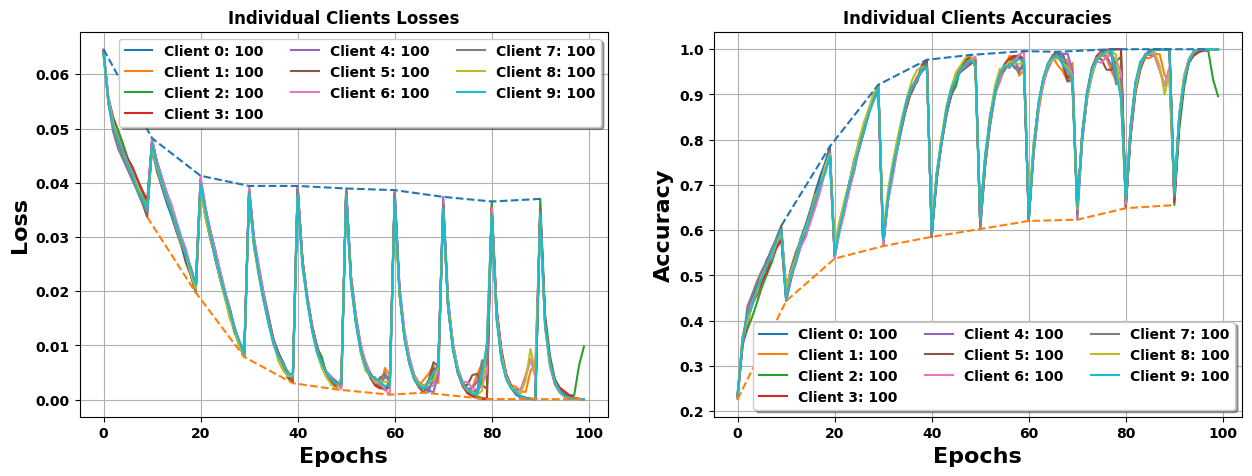

In [49]:
plot_metricss(strategy_fed_avg.client_metrics)

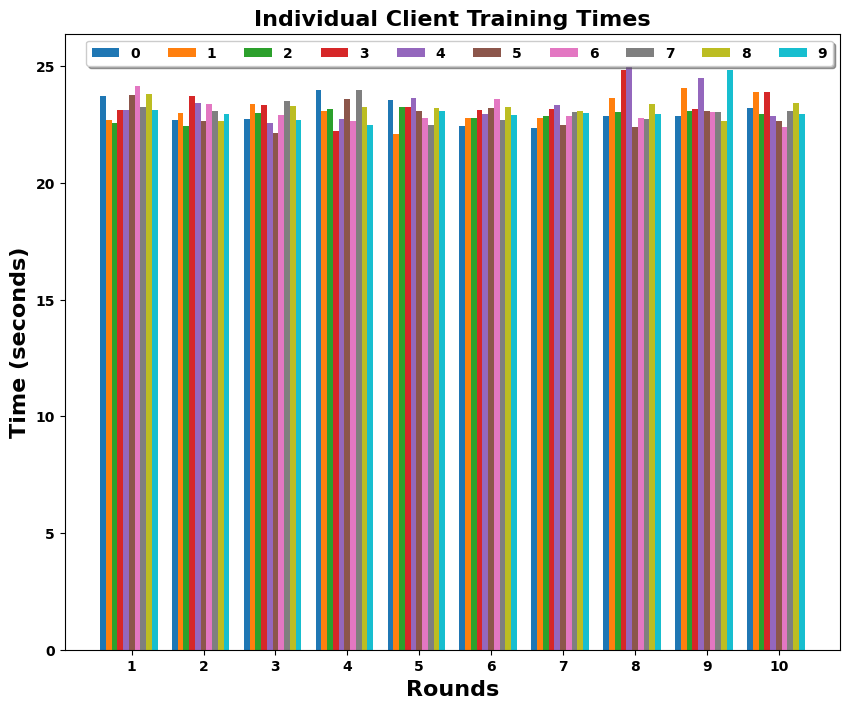

In [50]:
plot_times(strategy_fed_avg.client_training_times)

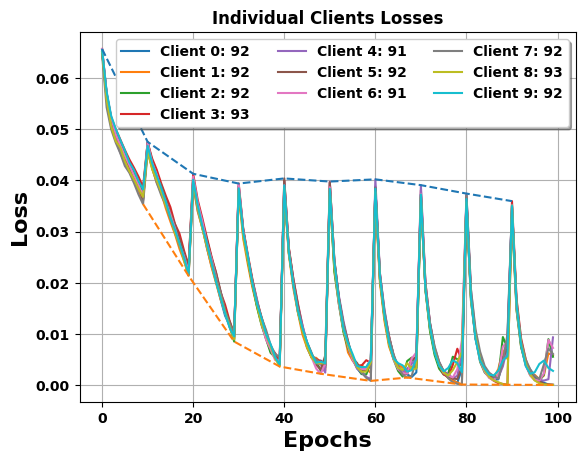

In [54]:
plot_metrics_loss(strategy_fed_avg.client_metrics)

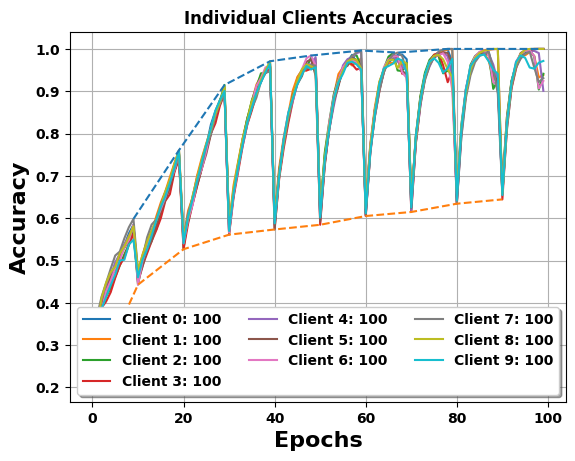

In [55]:
plot_metrics_acc(strategy_fed_avg.client_metrics)